In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import colorsys

In [3]:
sns.set_theme(style="ticks")
sns.set_style("whitegrid", {'axes.grid' : True})

In [81]:
def detect_invalid_file(data, file_name):
    custom = []
    adobe = []
    for test in data:
        if test['display mode'] == 'custom':
            custom += [test["test"]]
        elif test['display mode'] == 'adobe':
            adobe += [test["test"]]
    if sorted(custom) != sorted(adobe):
        print(f"{len(data)} - {file_name}: custom-{sorted(custom)} vs adobe-{sorted(adobe)}")
    else:
        pass
      
def correct_stage_numbers(data, file_name):
  stages = {}
  if "-ac-" in file_name:
      stages = {
        "adobe": 0,
        "custom": 1
      }
  elif "-ca-" in file_name:
      stages = {
        "adobe": 1,
        "custom": 0
      }
  for test in data:
      if test['stage'] != stages[test['display mode']]:
        print(f"Corrected stage number: {file_name}")
        test['stage'] = stages[test['display mode']]
  return data

def filter_tests(data, file_name):
    seen = {}
    filtered = []
    for test in data:
      t = test['test']
      # Remove test 0 and any duplicate tests
      if t != 0:
        mode = test['display mode']
        if mode not in seen:
          seen[mode] = set()
        if t not in seen[mode]:
          filtered.append(test)
          seen[mode].add(t)
    return filtered

def load_files_as_big_list(get="all"):
    output = []
    path_to_json = './Results/'
    json_files = [file for file in os.listdir(path_to_json) if file.endswith('.json')]
    first_iter = ["s-ca-mattbroughton.json", "s-ac-billy.json", "c-ac-tristan.json", "c-ac-kimi.json"]
    c = 0
    for file_name in json_files:
      # Remove participants for the first iteration
        if file_name in first_iter:
            continue
        if get=="ca" and (f"-{get}-") not in file_name:
            continue
        elif get=="ac" and (f"-{get}-") not in file_name:
            continue
        elif get=="all":
            pass
        c += 1
        with open(path_to_json + file_name) as f:
            data = json.load(f)
            data = correct_stage_numbers(data, file_name)
            data = filter_tests(data, file_name)
            detect_invalid_file(data, file_name)
            # note: I'm including an extra entry for name
            data += [{"file name":file_name.replace(".json", "")}]
            output += data
    print (f"Number of files: {c}\n")
    return output

all_files = load_files_as_big_list()

Corrected stage number: s-ac-kevin.json
Corrected stage number: s-ac-kevin.json
Corrected stage number: s-ac-kevin.json
Corrected stage number: s-ac-kevin.json
Corrected stage number: s-ac-kevin.json
Corrected stage number: s-ac-kevin.json
Corrected stage number: s-ac-kevin.json
Corrected stage number: s-ac-kevin.json
Corrected stage number: s-ac-kevin.json
Corrected stage number: s-ac-kevin.json
Corrected stage number: j-ac-sean.json
Corrected stage number: j-ac-sean.json
Corrected stage number: j-ac-sean.json
Corrected stage number: j-ac-sean.json
Corrected stage number: j-ac-sean.json
Corrected stage number: j-ac-sean.json
Corrected stage number: j-ac-sean.json
Corrected stage number: j-ac-sean.json
Corrected stage number: j-ac-sean.json
Corrected stage number: j-ac-sean.json
Corrected stage number: j-ca-lauren.json
Number of files: 27



In [82]:
columns=[header for header in all_files[0]]
print (columns)
myColumns = [
    'display mode', 'stage', 'test', 'target color', 
    'submitted color', 'selected colors', 'grid clicks', 'block clicks', 
    'strip clicks', 'compare clicks', 'time', 'file name'
] # not doing selected_colors just yet

['display mode', 'stage', 'test', 'target color', 'submitted color', 'selected colors', 'grid clicks', 'block clicks', 'strip clicks', 'compare clicks', 'time']


In [83]:
# data = {col:[] for col in myColumns}

def split_rgb_string(rgb):
    s = rgb.replace("(","").replace(")","")
    ls = s.split(",")
    return int(ls[0]), int(ls[1]), int(ls[2])

def parse_colors(myData):
    d = myData.copy()
    target_r = []
    target_g = []
    target_b = []
    submit_r = []
    submit_g = []
    submit_b = []
    target_h = []
    target_s = []
    target_v = []
    submit_h = []
    submit_s = []
    submit_v = []
    for ele in myData['target color']:
        r,g,b = split_rgb_string(ele)
        h,s,v = colorsys.rgb_to_hsv(r/255,g/255,b/255)
        target_r += [r]
        target_g += [g]
        target_b += [b]
        target_h += [h]
        target_s += [s]
        target_v += [v]
    for ele in myData['submitted color']:
        r,g,b = split_rgb_string(ele)
        h,s,v = colorsys.rgb_to_hsv(r/255,g/255,b/255)
        submit_r += [r]
        submit_g += [g]
        submit_b += [b] 
        submit_h += [h]
        submit_s += [s]
        submit_v += [v]
    
    del d['target color']
    del d['submitted color']
    
    d["target_r"] = target_r
    d["target_g"] = target_g
    d["target_b"] = target_b
    d["submit_r"] = submit_r
    d["submit_g"] = submit_g
    d["submit_b"] = submit_b
    
    d["target_h"] = target_h
    d["target_s"] = target_s
    d["target_v"] = target_v
    d["submit_h"] = submit_h
    d["submit_s"] = submit_s
    d["submit_v"] = submit_v
    
    d["r_diff"] = [abs(target_r[i] - submit_r[i]) for i in range(len(target_r))]
    d["g_diff"] = [abs(target_g[i] - submit_g[i]) for i in range(len(target_g))]
    d["b_diff"] = [abs(target_b[i] - submit_b[i]) for i in range(len(target_b))]
    
    d["h_diff"] = [abs(target_h[i] - submit_h[i]) for i in range(len(target_h))]
    d["s_diff"] = [abs(target_s[i] - submit_s[i]) for i in range(len(target_s))]
    d["v_diff"] = [abs(target_v[i] - submit_v[i]) for i in range(len(target_v))]
    
    
    d['total_rgb_diff'] = [np.linalg.norm([d["r_diff"][i], d["g_diff"][i], d["b_diff"][i]]) for i in range(len(target_r))]
    d['total_hsv_diff'] = [np.linalg.norm([d["h_diff"][i], d["s_diff"][i], d["v_diff"][i]]) for i in range(len(target_h))]
    
    d['num_selected'] = [len(test) for test in d['selected colors']] 
    return d  

def get_tabular_data(files):
    data = {col:[] for col in myColumns}
    count = 0
    for file in files:
        if "file name" in file:
            data['file name'] += [file['file name'] for i in range(count)]
            count = 0
        else:
            count += 1
            for ele in file:
                data[ele] += [file[ele]]
    return parse_colors(data)

all_data = get_tabular_data(all_files)
all_df = pd.DataFrame(all_data)
print (f"{len(all_files)} vs {len(all_df)}\n")
# NOTE: The difference is values is related to the filename

513 vs 486



In [38]:
all_df.head()

,display mode,stage,test,selected colors,grid clicks,block clicks,strip clicks,compare clicks,time,file name,...,submit_v,r_diff,g_diff,b_diff,h_diff,s_diff,v_diff,total_rgb_diff,total_hsv_diff,num_selected
0,custom,0,1,"[(127,102,63), (152,109,42), (152,109,42), (17...",69,2,4,32,119.619,j-ca-claire,...,0.662745,2,4,8,0.011804,0.043865,0.007843,9.165151,0.046097,75
1,custom,0,2,"[(127,63,90), (190,67,119), (156,34,85), (181,...",32,5,4,29,103.108,j-ca-claire,...,0.682353,0,6,5,0.007780,0.034483,0.000000,7.810250,0.035349,41
2,custom,0,3,"[(76,63,127), (108,63,127), (60,13,81), (60,13...",10,11,2,9,47.421,j-ca-claire,...,0.301961,4,0,1,0.013945,0.006494,0.003922,4.123106,0.015875,23
3,custom,0,4,"[(127,63,115), (127,63,73), (127,63,89), (209,...",11,13,7,16,92.856,j-ca-claire,...,0.760784,2,0,7,0.008343,0.003840,0.007843,7.280110,0.012077,31
4,custom,0,5,"[(127,101,63), (127,74,63), (127,95,63), (210,...",12,11,4,12,69.663,j-ca-claire,...,0.811765,0,1,7,0.005617,0.033816,0.000000,7.071068,0.034280,27


In [39]:
subset_cols = [
    "grid clicks", "block clicks", "strip clicks", "compare clicks", 
    "time", "r_diff", "g_diff", "b_diff", "h_diff", "s_diff", "v_diff", 'num_selected','total_rgb_diff', 'total_hsv_diff'
]
# all_df.groupby(["display mode"]).mean()
all_df.groupby(["display mode"]).mean()[subset_cols]

,grid clicks,block clicks,strip clicks,compare clicks,time,r_diff,g_diff,b_diff,h_diff,s_diff,v_diff,num_selected,total_rgb_diff,total_hsv_diff
display mode,,,,,,,,,,,,,,
adobe,0.000000,19.304527,4.798354,14.600823,69.125029,9.617284,4.621399,8.909465,0.038611,0.068661,0.023659,23.699588,17.085845,0.103990
custom,17.440329,8.962963,4.748971,20.131687,90.325852,10.275720,4.275720,7.946502,0.028003,0.066914,0.020382,30.864198,16.703560,0.089082


Comments
- Users spent `more time with custom` but were `more accurate on average` across all 3 values of rgb
- Users spent `about the same time clicking the rainbow slider`, but had `disproportionate number of block clicks`. With the custom picker, there was a significant lesser amount of block-clicks. The differences in grid-clicks is related to the nature of the tests.
- Users selected `slightly more colors` with the custom than the adobe color picker.
- The average total difference between target and selected is `slightly lower` for users using the custom color picker than the adobe one. 

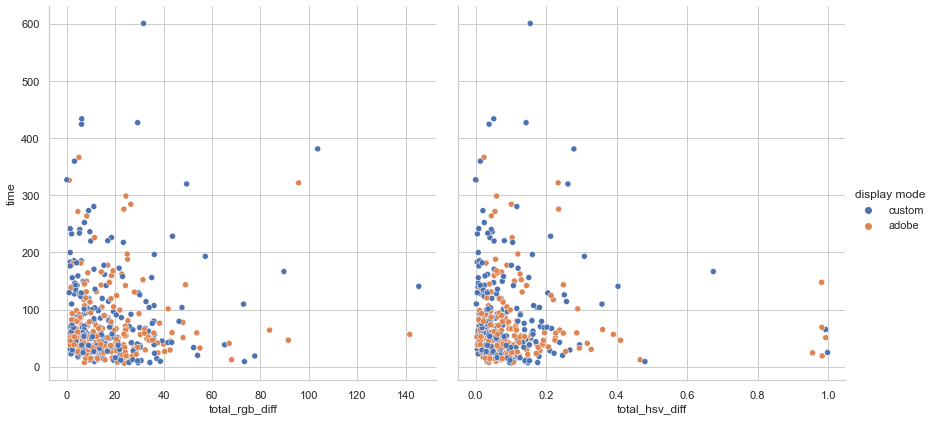

In [40]:
g = sns.PairGrid(all_df, y_vars=["time"], x_vars=["total_rgb_diff", "total_hsv_diff"], hue="display mode", height=6, aspect=1)
g.map(sns.scatterplot)
g.add_legend()

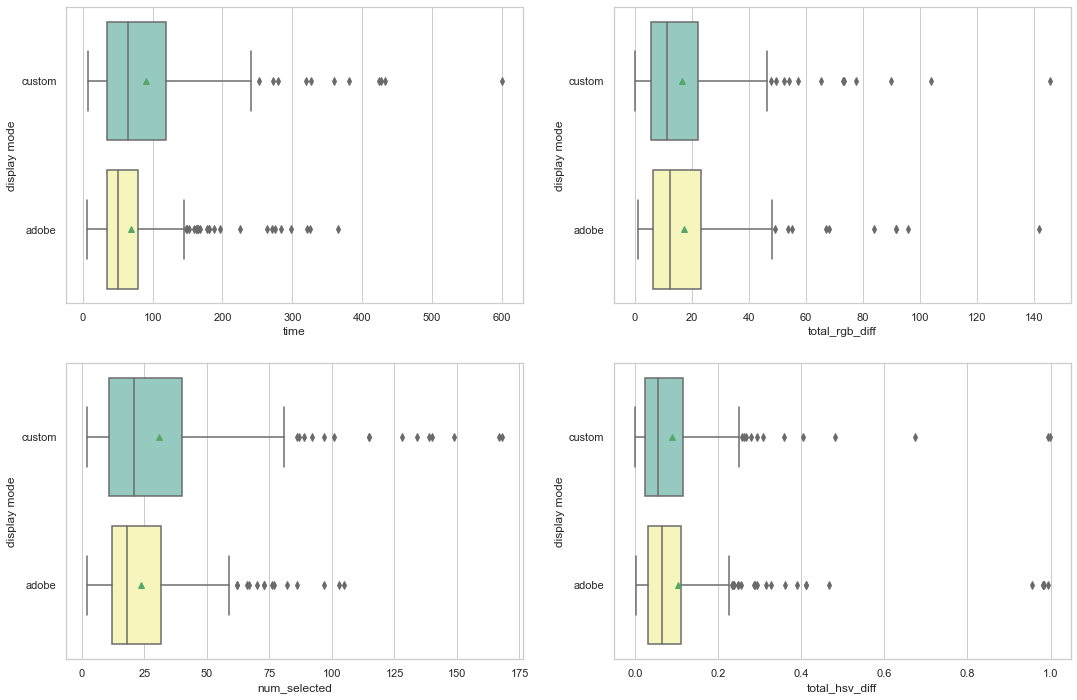

In [41]:
fig, axs = plt.subplots(2,2, figsize=(18,12))
sns.boxplot(y="display mode", x="time", data=all_df, palette="Set3", orient="h", showmeans=True, ax=axs[0][0])
sns.boxplot(y="display mode", x="total_rgb_diff", data=all_df, palette="Set3", orient="h", showmeans=True, ax=axs[0][1])
sns.boxplot(y="display mode", x="num_selected", data=all_df, palette="Set3", orient="h", showmeans=True, ax=axs[1][0])
sns.boxplot(y="display mode", x="total_hsv_diff", data=all_df, palette="Set3", orient="h", showmeans=True, ax=axs[1][1])
plt.show();

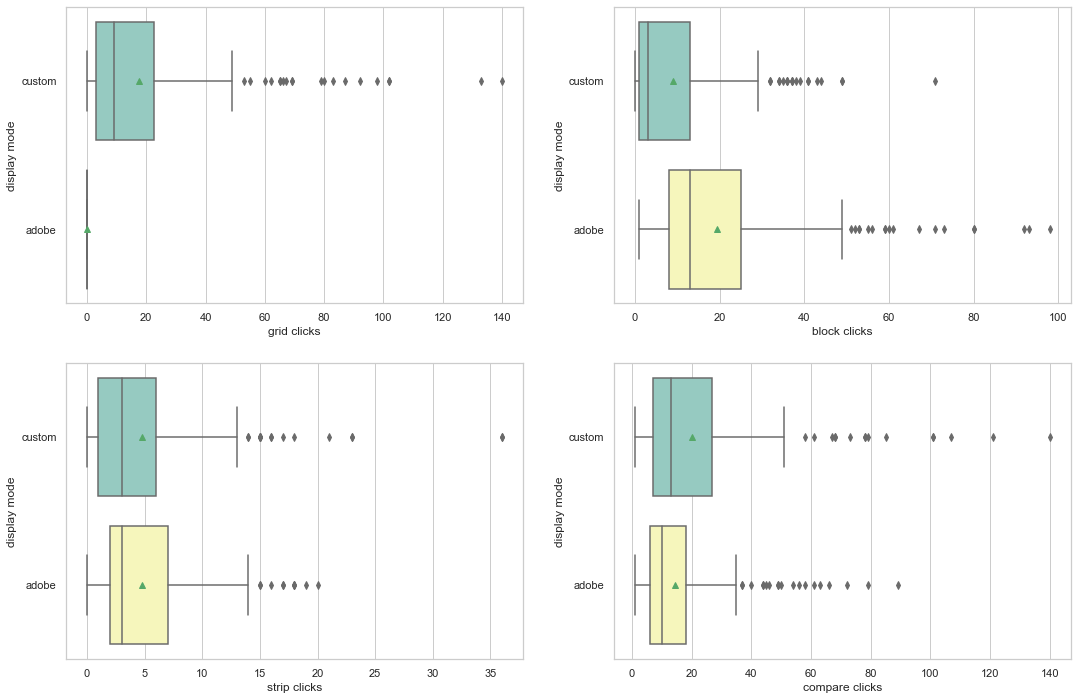

In [42]:
fig, axs = plt.subplots(2,2, figsize=(18,12))
sns.boxplot(y="display mode", x="grid clicks", data=all_df, palette="Set3", orient="h", ax=axs[0][0], showmeans=True)
sns.boxplot(y="display mode", x="block clicks", data=all_df, palette="Set3", orient="h", ax=axs[0][1], showmeans=True)
sns.boxplot(y="display mode", x="strip clicks", data=all_df, palette="Set3", orient="h", ax=axs[1][0], showmeans=True)
sns.boxplot(y="display mode", x="compare clicks", data=all_df, palette="Set3", orient="h", ax=axs[1][1], showmeans=True)
plt.show()

In [43]:
describe_columns = [
    "grid clicks","block clicks","strip clicks",
    "compare clicks","time","total_rgb_diff","total_hsv_diff",'num_selected',
]

In [44]:
all_df[all_df['display mode'] == "custom"].describe()[describe_columns]

,grid clicks,block clicks,strip clicks,compare clicks,time,total_rgb_diff,total_hsv_diff,num_selected
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,17.440329,8.962963,4.748971,20.131687,90.325852,16.703560,0.089082,30.864198
std,23.397207,12.022477,5.085910,21.466078,84.841118,17.952857,0.118446,29.952615
min,0.000000,0.000000,0.000000,1.000000,6.992000,0.000000,0.000000,2.000000
25%,3.000000,1.000000,1.000000,7.000000,34.634500,5.567040,0.024639,11.000000
50%,9.000000,3.000000,3.000000,13.000000,64.680000,11.180340,0.054738,21.000000
75%,22.500000,13.000000,6.000000,27.000000,119.485500,22.010303,0.116994,40.000000
max,140.000000,71.000000,36.000000,140.000000,600.417000,145.399450,0.998244,168.000000


In [45]:
all_df[all_df['display mode'] == "adobe"].describe()[describe_columns]

,grid clicks,block clicks,strip clicks,compare clicks,time,total_rgb_diff,total_hsv_diff,num_selected
count,243.0,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,0.0,19.304527,4.798354,14.600823,69.125029,17.085845,0.103990,23.699588
std,0.0,17.366904,4.138670,14.282897,59.375653,17.369461,0.150129,18.602749
min,0.0,1.000000,0.000000,1.000000,6.008000,1.000000,0.002525,2.000000
25%,0.0,8.000000,2.000000,6.000000,35.200000,6.363840,0.031388,12.000000
50%,0.0,13.000000,3.000000,10.000000,51.001000,12.328828,0.064401,18.000000
75%,0.0,25.000000,7.000000,18.000000,79.156500,23.032583,0.110158,31.500000
max,0.0,98.000000,20.000000,89.000000,366.033000,141.654509,0.993083,105.000000


Explore the following visualizations
- https://seaborn.pydata.org/examples/grouped_boxplot.html
- https://seaborn.pydata.org/examples/horizontal_boxplot.html
- https://seaborn.pydata.org/examples/faceted_histogram.html
- https://seaborn.pydata.org/examples/anscombes_quartet.html
- https://seaborn.pydata.org/examples/scatterplot_matrix.html
- https://seaborn.pydata.org/examples/wide_form_violinplot.html

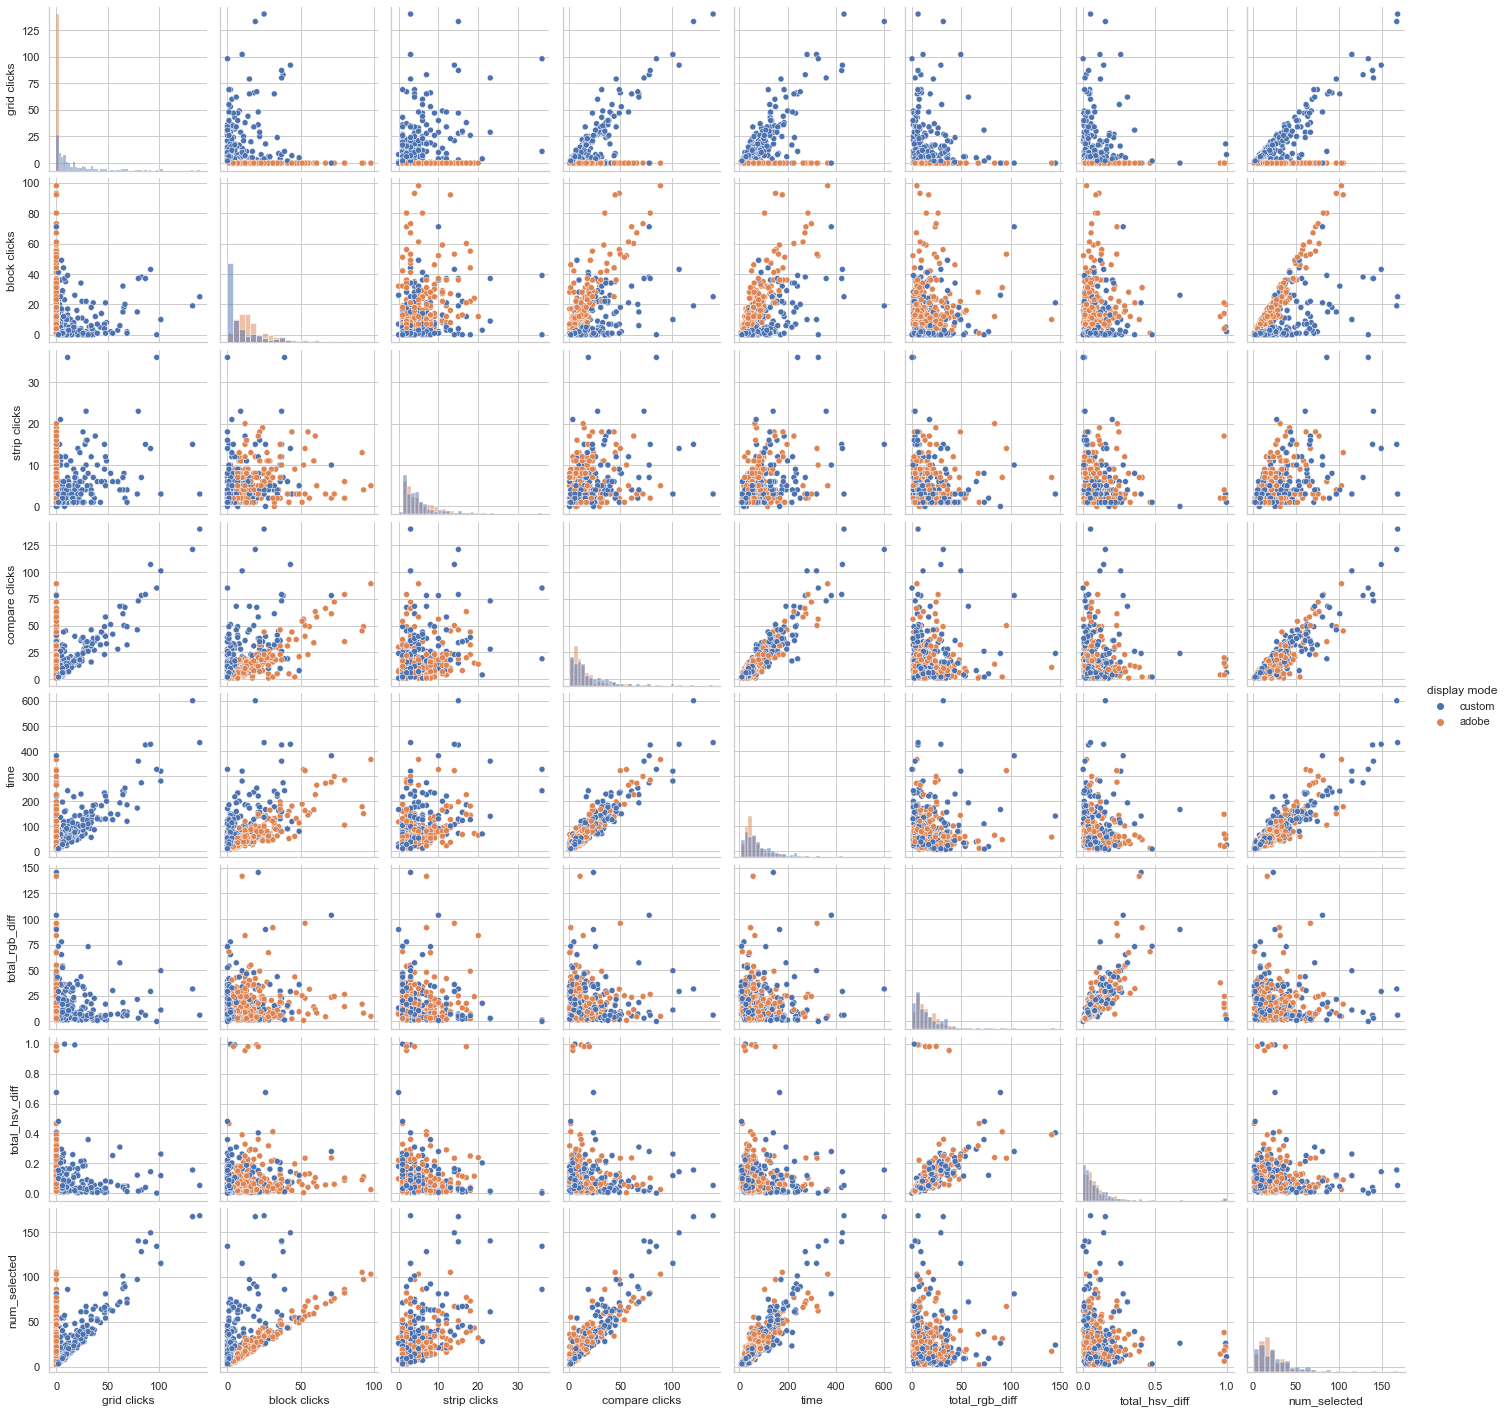

In [46]:
sns.pairplot(
    all_df[describe_columns + ["display mode"]], 
    hue='display mode',
    diag_kind="hist", # feel free to remove this parameter for more visually appealing distributions
)
plt.show()

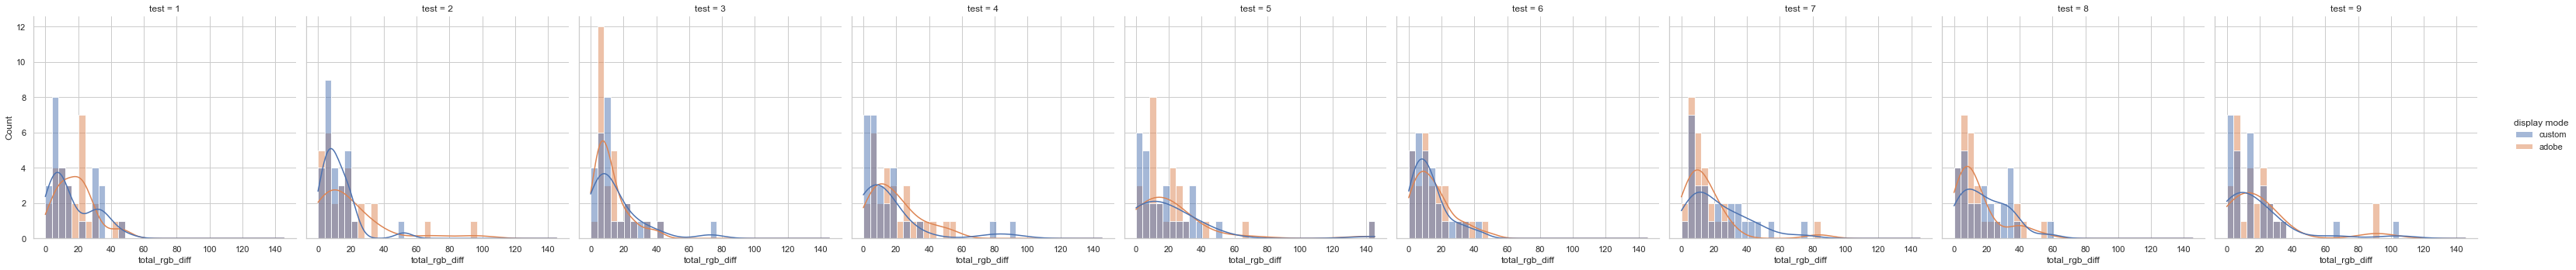

In [47]:
sns.displot(data=all_df, x="total_rgb_diff", hue="display mode", col="test",kde=True)
plt.show()

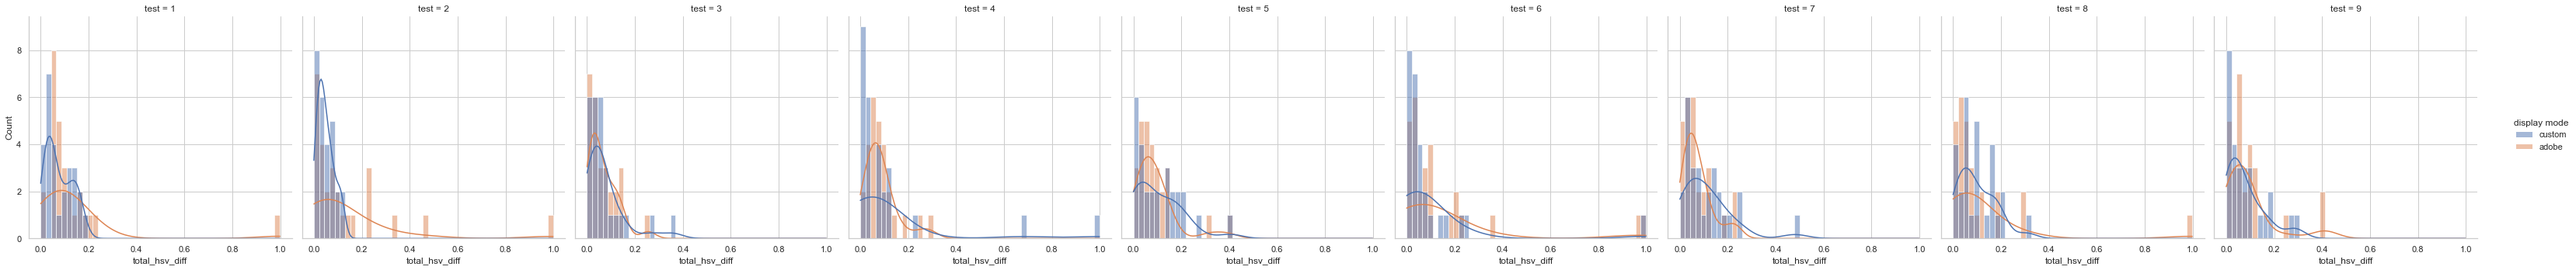

In [48]:
sns.displot(data=all_df, x="total_hsv_diff", hue="display mode", col="test",kde=True)
plt.show()

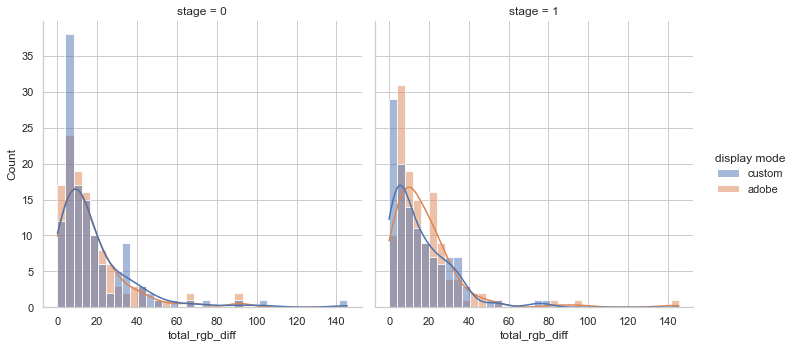

In [49]:
sns.displot(data=all_df, x="total_rgb_diff", hue="display mode", col="stage",kde=True)
plt.show()

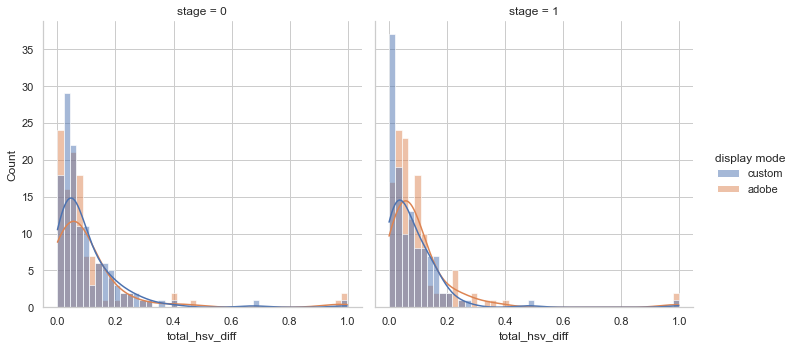

In [50]:
sns.displot(data=all_df, x="total_hsv_diff", hue="display mode", col="stage",kde=True)
plt.show()

# Pre-Study Data

In [51]:
# Load data from file
prestudy_file = "ColorPicker_ Pre-Study Survey (Responses) - Form Responses 1.csv"
prestudy_df = pd.read_csv(prestudy_file)
prestudy_df.head()

,Timestamp,First Name,Last Name,Age,Gender,"If you clicked ""prefer to self-describe"" above, please elaborate here",How often do you make NON-DIGITAL visual art?,How knowledgable or experienced do you consider yourself in NON-DIGITAL visual art tools?,Please select all of the following NON-DIGITAL artistic medium that you would consider yourself to be proficient at:,How often do you make DIGITAL visual art?,How knowledgable or experienced do you consider yourself in DIGITAL visual art tools?,Please select all of the following DIGITAL artistic medium that you would consider yourself to be proficient at:,"Note: You do not have to have seen the picker within the same software as the example, but if you are familiar with a color picker that uses the same mechanism (eg. for Color Search, searching for a color using its name), please select it.",Do you have any visual impairments?,"If yes, does it affect your ability to differentiate between colors? Please explain."
0,4/2/2021 21:05:13,Matthew,Broughton,21,Man,NaN,A few time a year,2,"Graphite, Color Pencil",About once a week,2,"MS Paint, Procreate, Gimp","Color Wheel, HSB Color Map, RGB Sliders, HSB S...",No,NaN
1,4/2/2021 21:33:22,Matthew,Vanegas,22,Man,NaN,Less than once a year,1,Spray paint,Less than once a year,1,"MS Paint, Gimp","Color Search, Color Wheel, 2D Spectrum, HSB Co...",No,NaN
2,4/2/2021 23:03:12,Helen,He,22,Woman,NaN,A few time a year,3,"Graphite, Watercolor, Oil Paint, Acrylic",About once a month,4,"MS Paint, Adobe Creative Suite (includes photo...","Color Search, Crayon Selector, Color Wheel, 2D...",No,NaN
3,4/2/2021 23:06:33,Eleanor,Chen,21,Woman,NaN,About once a month,4,"Graphite, Color Pencil, Color Marker, Watercol...",About once a month,4,"Adobe Creative Suite (includes photoshop), Ske...","Color Wheel, HSB Color Map, RGB Sliders, HSB S...",No,NaN
4,4/2/2021 23:56:37,Kevin,Li,22,Man,NaN,About once a week,3,"Graphite, Chalk Pastel",About once a month,4,"Adobe Creative Suite (includes photoshop), Sketch","Color Search, Crayon Selector, Color Wheel, 2D...",No,NaN


In [52]:
names_to_files = {
  "Matthew Broughton": "s-ca-mattbroughton",
  "Matthew Vanegas": "s-ca-mattvanegas",
  "Helen He": "s-ac-helen",
  "Eleanor Chen": "s-ca-eleanor",
  "Kevin Li": "s-ac-kevin",
  "Serena Cheng": "s-ac-serena",
  "Erin Yoo": "s-ca-erin",
  "Billy Chiu": "s-ac-billy",
  "Elizabeth Lee": "j-ac-elizabeth",
  "Iris Zhao": "j-ac-iris",
  "Virginia Jiang": "j-ac-virginia",
  "Sarah Huang": "j-ac-sarah",
  "Iliana Cantu": "j-ca-iliana",
  "Lauren Alcindor": "j-ca-lauren",
  "Sean Wang": "j-ac-sean",
  "Michelle Lin": "j-ca-michelle",
  "Miranda Fatolitis": "j-ca-miranda",
  "Michele Wu": "s-ac-michele",
  "Rachel He": "s-ca-rachel",
  "Claire Yang": "j-ca-claire",
  "Han Wen Zhang": "s-ac-hanwen",
  "Tuhfa Begum": "j-ca-tuhfa",
  "Tristan Ang": "c-ac-tristan",
  "Sarah Leventhal": "c-ac-sarah",
  "Kimi Wenzel": "c-ac-kimi",
  "Rachel Chung": "c-ac-rachel",
  "Selena Wang": "c-ac-selena",
  "Alexandra Eguiluz": "c-ca-alexandra",
  "Saphicher Gonzalez": "c-ca-saphi",
  "Nicole Hong": "c-ca-nicole",
  "Sergio Rosas": "c-ca-sergio"
}

def get_file_name(entry):
  name = f"{entry['First Name'].strip()} {entry['Last Name'].strip()}"
  return names_to_files[name]

prestudy_df['file name'] = prestudy_df.apply(lambda row: get_file_name(row), axis=1)
prestudy_df = prestudy_df.set_index('file name')

In [53]:
exp_col = "How knowledgable or experienced do you consider yourself in DIGITAL visual art tools?"
exp_df = prestudy_df[exp_col] >= 4
all_df_w_exp = all_df.join(exp_df, on="file name").rename(columns={exp_col: "experienced"})
len(prestudy_df[exp_df])

10

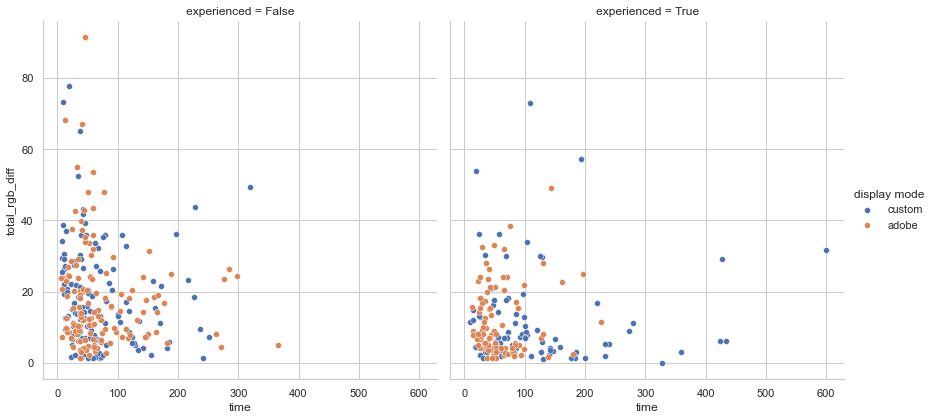

In [54]:
g = sns.FacetGrid(all_df_w_exp, col="experienced", hue="display mode", height=6, aspect=1)
g.map(sns.scatterplot, "time", "total_rgb_diff")
g.add_legend()

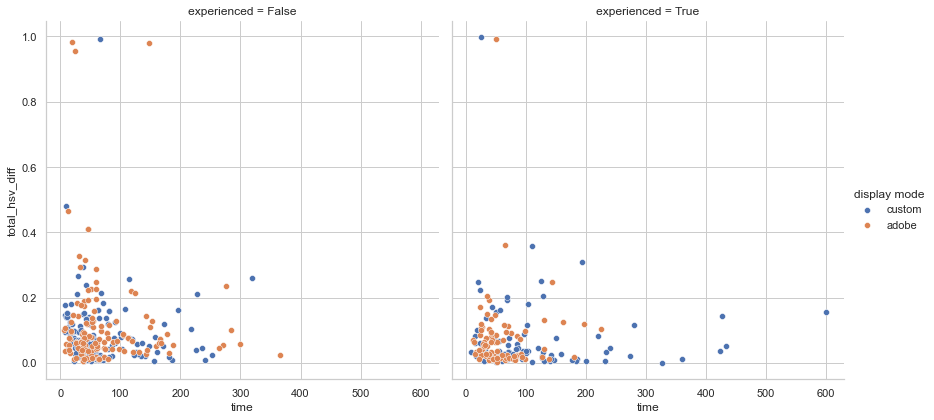

In [55]:
g = sns.FacetGrid(all_df_w_exp, col="experienced", hue="display mode", height=6, aspect=1)
g.map(sns.scatterplot, "time", "total_hsv_diff")
g.add_legend()

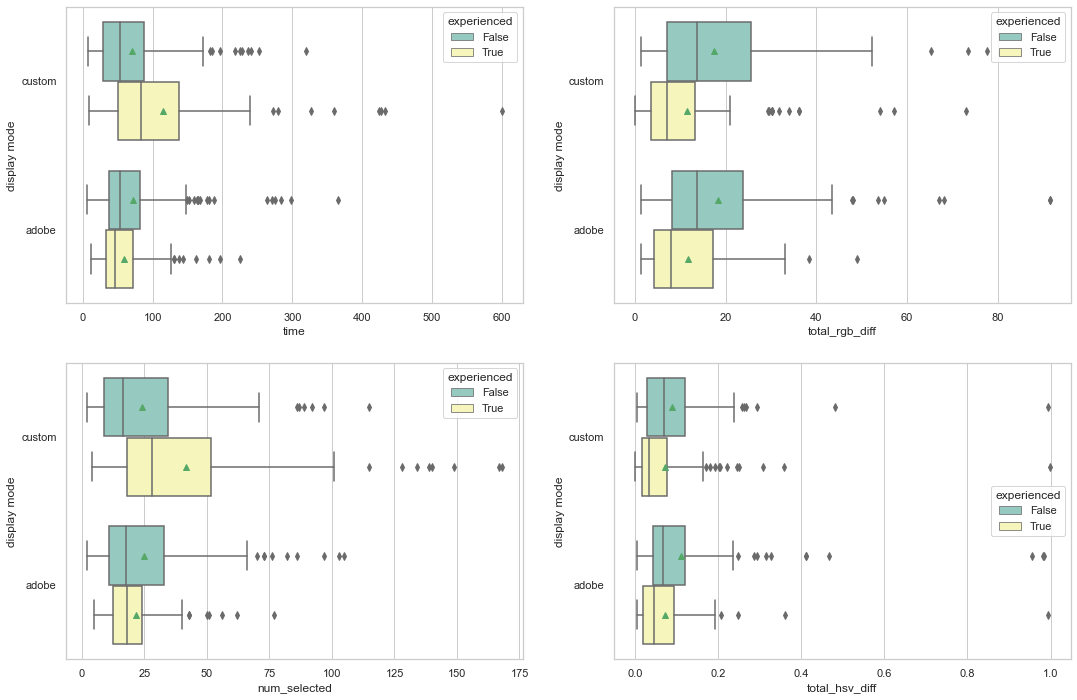

In [56]:
fig, axs = plt.subplots(2,2, figsize=(18,12))
sns.boxplot(y="display mode", x="time", hue="experienced", data=all_df_w_exp, palette="Set3", orient="h", showmeans=True, ax=axs[0][0])
sns.boxplot(y="display mode", x="total_rgb_diff", hue="experienced", data=all_df_w_exp, palette="Set3", orient="h", showmeans=True, ax=axs[0][1])
sns.boxplot(y="display mode", x="num_selected", hue="experienced", data=all_df_w_exp, palette="Set3", orient="h", showmeans=True, ax=axs[1][0])
sns.boxplot(y="display mode", x="total_hsv_diff", hue="experienced", data=all_df_w_exp, palette="Set3", orient="h", showmeans=True, ax=axs[1][1])
plt.show()

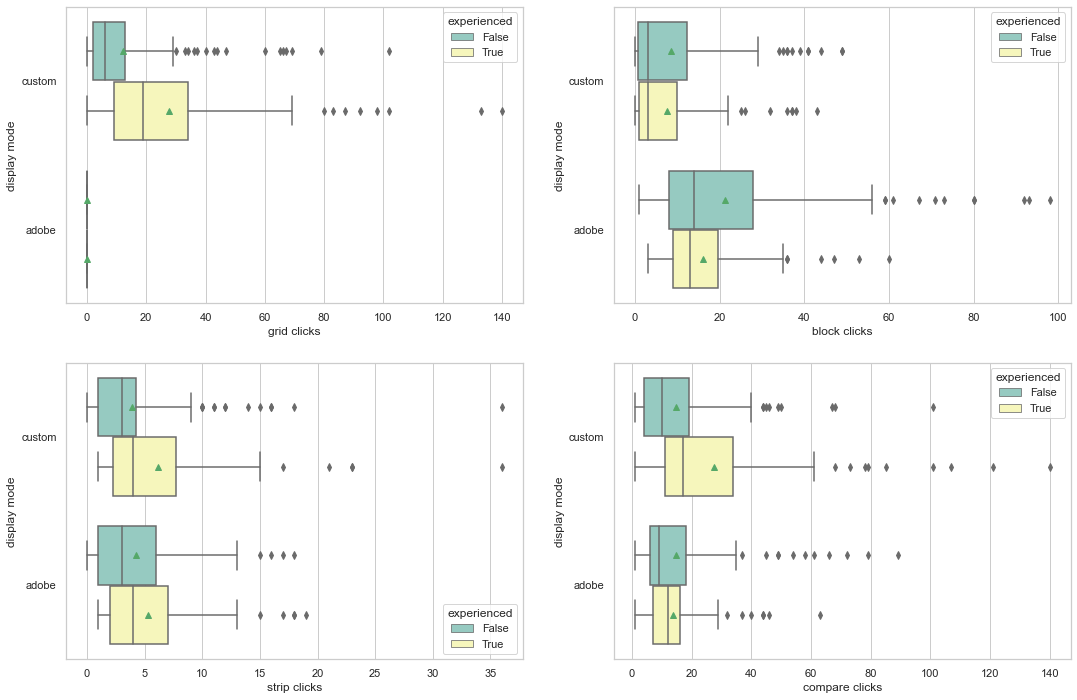

In [57]:
fig, axs = plt.subplots(2,2, figsize=(18,12))
sns.boxplot(y="display mode", x="grid clicks", hue="experienced", data=all_df_w_exp, palette="Set3", orient="h", ax=axs[0][0], showmeans=True)
sns.boxplot(y="display mode", x="block clicks", hue="experienced", data=all_df_w_exp, palette="Set3", orient="h", ax=axs[0][1], showmeans=True)
sns.boxplot(y="display mode", x="strip clicks", hue="experienced", data=all_df_w_exp, palette="Set3", orient="h", ax=axs[1][0], showmeans=True)
sns.boxplot(y="display mode", x="compare clicks", hue="experienced", data=all_df_w_exp, palette="Set3", orient="h", ax=axs[1][1], showmeans=True)
plt.show()

# HSV Diffs

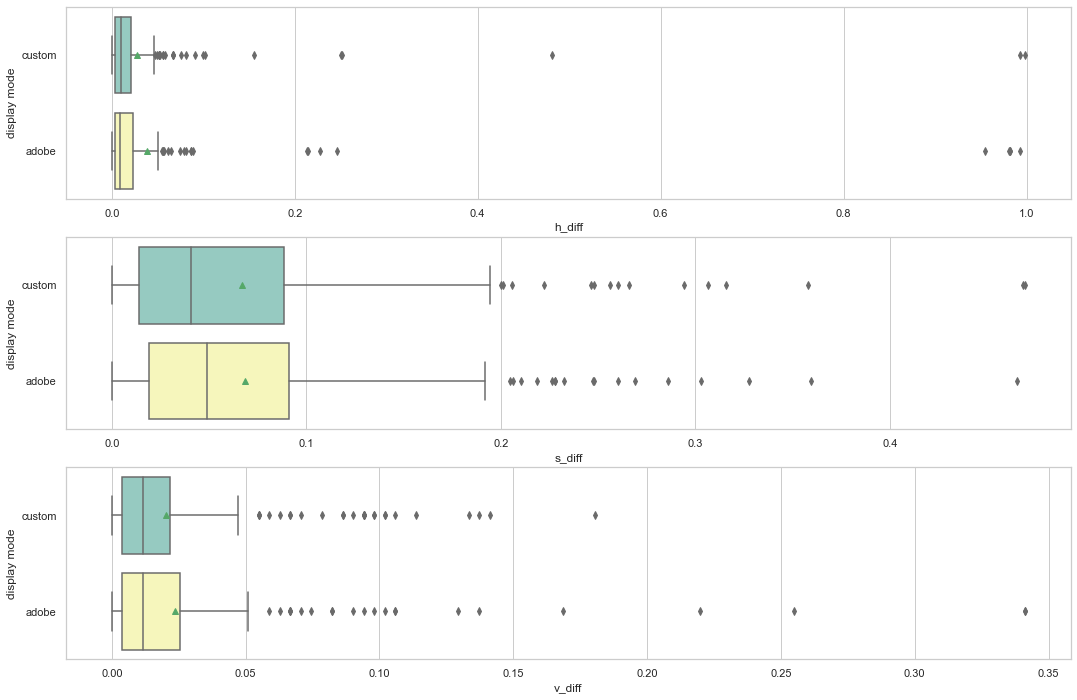

In [58]:
fig, axs = plt.subplots(3,1, figsize=(18,12))
sns.boxplot(y="display mode", x="h_diff", data=all_df_w_exp, palette="Set3", orient="h", ax=axs[0], showmeans=True)
sns.boxplot(y="display mode", x="s_diff", data=all_df_w_exp, palette="Set3", orient="h", ax=axs[1], showmeans=True)
sns.boxplot(y="display mode", x="v_diff", data=all_df_w_exp, palette="Set3", orient="h", ax=axs[2], showmeans=True)
plt.show()

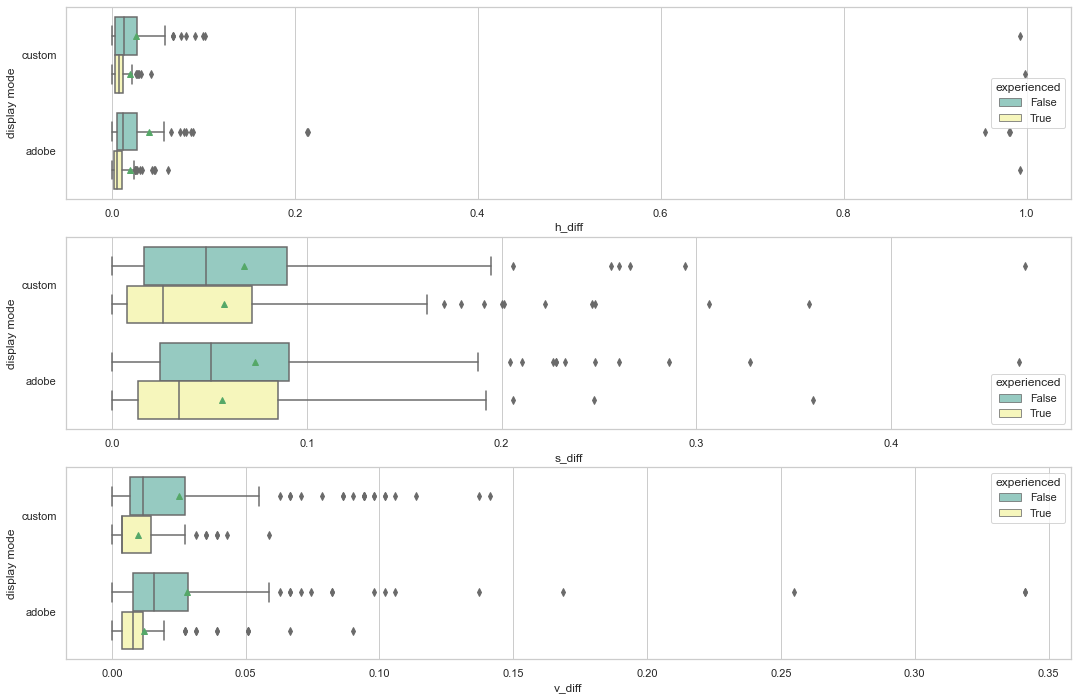

In [59]:
fig, axs = plt.subplots(3,1, figsize=(18,12))
sns.boxplot(y="display mode", x="h_diff", hue="experienced", data=all_df_w_exp, palette="Set3", orient="h", ax=axs[0], showmeans=True)
sns.boxplot(y="display mode", x="s_diff", hue="experienced", data=all_df_w_exp, palette="Set3", orient="h", ax=axs[1], showmeans=True)
sns.boxplot(y="display mode", x="v_diff", hue="experienced", data=all_df_w_exp, palette="Set3", orient="h", ax=axs[2], showmeans=True)
plt.show()

# Modes, Stages, Tests

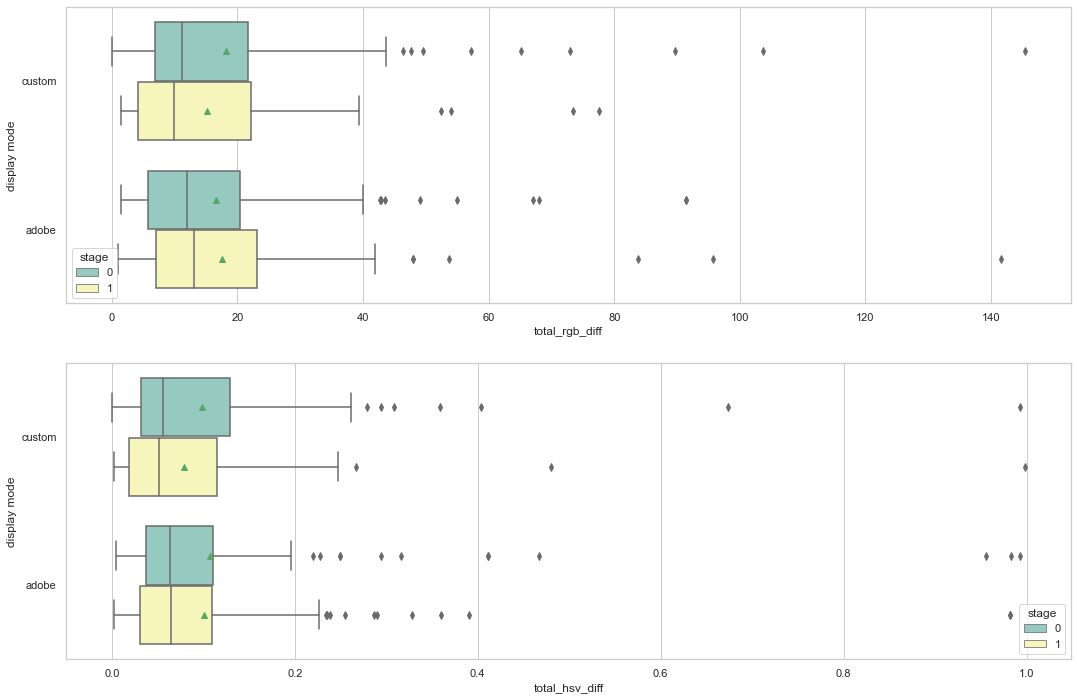

In [67]:
fig, axs = plt.subplots(2,1, figsize=(18,12))
sns.boxplot(y="display mode", x="total_rgb_diff", hue="stage", data=all_df, palette="Set3", orient="h", ax=axs[0], showmeans=True)
sns.boxplot(y="display mode", x="total_hsv_diff", hue="stage", data=all_df, palette="Set3", orient="h", ax=axs[1], showmeans=True)
plt.show()

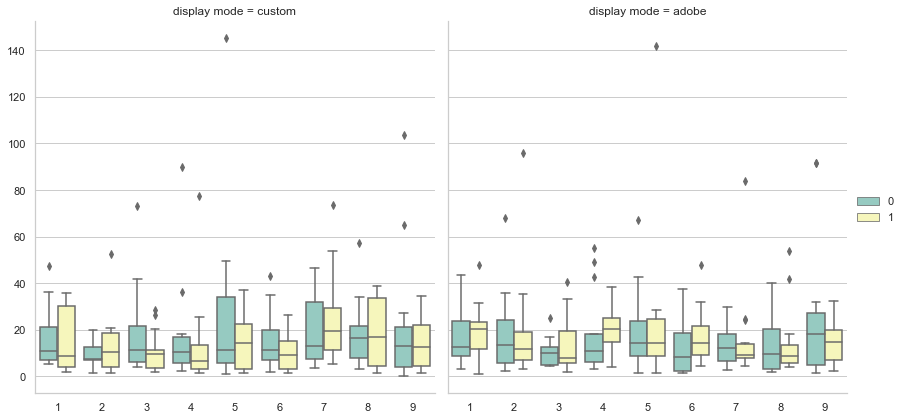

In [63]:
g = sns.FacetGrid(all_df, col="display mode", height=6, aspect=1)
g.map_dataframe(sns.boxplot, x="test", y="total_rgb_diff", hue="stage", palette="Set3")
g.add_legend()

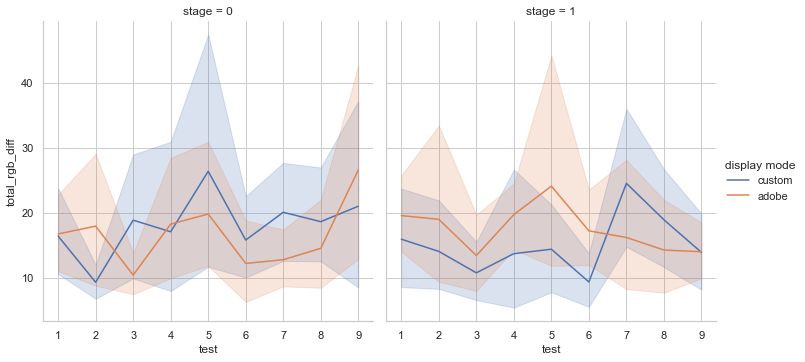

In [66]:
sns.relplot(
    data=all_df, kind="line",
    x="test", y="total_rgb_diff", col="stage",
    hue="display mode"
)

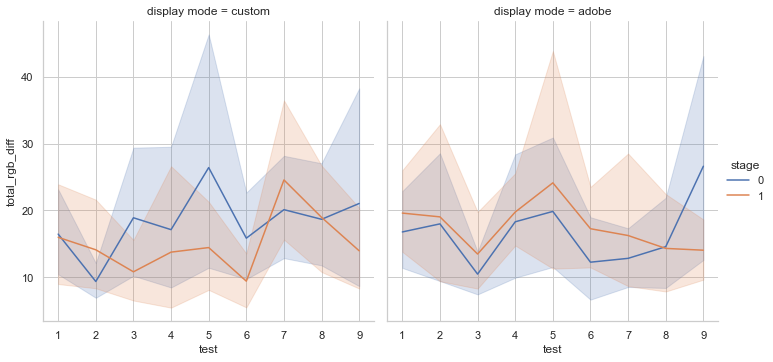

In [65]:
sns.relplot(
    data=all_df, kind="line",
    x="test", y="total_rgb_diff", col="display mode",
    hue="stage"
)

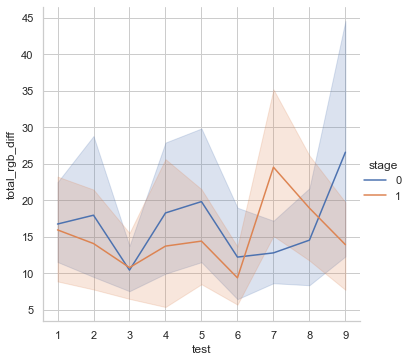

In [102]:
# AC order
ac = all_df[(all_df["display mode"]=="adobe") & (all_df["stage"]==0) | (all_df["display mode"]=="custom") & (all_df["stage"]==1)]
sns.relplot(
    data=ac, kind="line",
    x="test", y="total_rgb_diff",
    hue="stage"
)

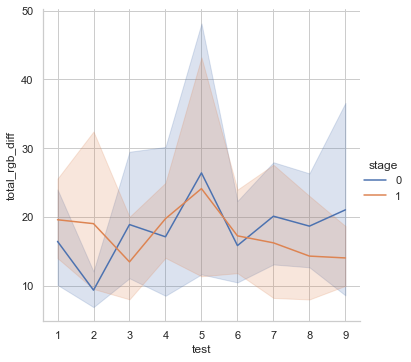

In [101]:
# CA order
ca = all_df[(all_df["display mode"]=="adobe") & (all_df["stage"]==1) | (all_df["display mode"]=="custom") & (all_df["stage"]==0)]
sns.relplot(
    data=ca, kind="line",
    x="test", y="total_rgb_diff",
    hue="stage"
)

Maybe try:
- Normalize diff by person's average (people have different definitions of "acceptable")?
- Number of color selections to reach a certain threshold of closeness to the target color?
- Visualize one person's test?